# **Analisis de sentimiento - Red Neuronal**  (tensorflow / keras)
### Proyecto mineria de datos - 2021
---
##### Ela Katherine Shepherd Arévalo - Pablo Daurell Marina

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import shutil
import string
import pickle
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
'''Importar dataset de Drive'''
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


- El objetivo de este notebook será entrenar una red neuronal con Tensorflow, capaz de analizar el sentimiento (positivo o negativo) de distintos tweets
- Para ello crearemos un modelo de red neuronal con Tensorflow (Keras) y lo entrenaremos utilizando el dataset ([Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140)) que contiene 1.6 millones de tweets (generalmente en inglés), clasificados como positivos o negativos.

## 1. Cargar dataset de tweets

- Importamos el dataset de tweets, con 1.6 millones de elementos.
- Quitamos las columnas innecesarias, como la fecha, el usuario, el id o la query.
- El dataset original indica sentimiento negativo con un 0 y positivo con un 4. Por comodidad, sustituimos el 4 por un 1.

In [ ]:
file = "/content/drive/MyDrive/Mineria/sentiment140.csv"
data = pd.read_csv(file, encoding='latin', names=['sentiment','id','date','query','user','text'])
data = data.drop(columns=['date', 'query', 'user', 'id'])
data['sentiment'] = data['sentiment'].replace(4, 1)
print('Shape: ', data.shape)

Shape:  (1600000, 2)


In [ ]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


- Vemos cuantos tweets de cada sentimiento hay:

In [ ]:
data_text = data['text']
data_label = data['sentiment']

In [ ]:
print('Dataset shape: ', data.shape)
print('Negative tweets: ', np.count_nonzero(data_label == 0))
print('Positive tweets: ', np.count_nonzero(data_label == 1))

Dataset shape:  (1600000, 2)
Negative tweets:  800000
Positive tweets:  800000


## 2. Dividir train, validation, test

- Dividimos el dataset en un conjunto de **entrenamiento** (con un **70%** de los ejemplares), otro conjunto de **validación** (con un **15%** de los ejemplares) y un conjunto de **testeo** (con el **15%** restante de los ejemplares)

In [ ]:
from sklearn.model_selection import train_test_split

### 70% train, 30% aux (15% val, 15% test)
train_data, aux_data, train_label, aux_label = train_test_split(data_text, data_label, 
                                                        test_size=0.30, stratify=data_label)

### 15% val, 15% test
val_data, test_data, val_label, test_label = train_test_split(aux_data, aux_label, 
                                              test_size=0.5, stratify=aux_label)

In [ ]:
print('Train: {}, Val: {}, Test: {}'.format(train_data.shape, val_data.shape, test_data.shape))

Train: (1120000,), Val: (240000,), Test: (240000,)


- Convertimos los datos de **pandas** Dataframe a **tensorflow** dataset



In [ ]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_label))
raw_test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_label))

In [ ]:
for feat, targ in raw_train_ds.take(5):
    print('Features: {}, Target: {}'.format(feat, targ))

Features: b'@ddlovato &amp; @thebrandicyrus i luv it tooooo ', Target: 1
Features: b"@Cire77 screw u hippies! We're gonna have meat lots and lots ", Target: 1
Features: b'@tommcfly NOOOO, please! black and white confused my mind, please ', Target: 0
Features: b"so tired.. still got a achy head and heart  (it's 23:22 in germany) love ya &lt;3", Target: 0
Features: b"workout video &lt; swimming &lt; iChat with just about everyone. Can't wait for tomorrow! ", Target: 1


In [ ]:
len(raw_train_ds)

1120000

- Para facilitar el trabajo a la red neuronal, agrupamos los elementos del dataset en **batchs**:

In [ ]:
batch_size = 128
raw_train_ds_batched = raw_train_ds.batch(batch_size)
raw_val_ds_batched = raw_val_ds.batch(batch_size)
raw_test_ds_batched = raw_test_ds.batch(batch_size)

In [ ]:
len(raw_train_ds_batched)

8750

In [ ]:
for feat_batch, targ_batch in raw_train_ds_batched.take(1):
  for i in range(3):
    print('Features: {}, Target: {}'.format(feat_batch.numpy()[i], targ_batch.numpy()[i]))

Features: b'@ddlovato &amp; @thebrandicyrus i luv it tooooo ', Target: 1
Features: b"@Cire77 screw u hippies! We're gonna have meat lots and lots ", Target: 1
Features: b'@tommcfly NOOOO, please! black and white confused my mind, please ', Target: 0


## 3. Preprocesar datos de entrada

- Antes de introducir los datos en la red neuronal es necesario algo de preprocesamiento:
> - Pasamos todo a minúsculas
> - Eliminamos los nombres de usuarios (*@usuario*), caracteres especiales, y enlaces


In [ ]:
### Funcion para estandarizar los tweets ###

@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)

  # Eliminar menciones (@username), enlaces, o caracteres especiales
  clean_tweet = tf.strings.regex_replace(lowercase,
                            '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(www.\S+)', ' ') #
  return clean_tweet

In [ ]:
# Ejemplo de tweet estandarizado
custom_standardization('@isilwath Babies are absolutely adorable.  Watching &quot;moving hot tub&quot; movie now - expecting a Am Funniest Home Video moment... O.o')

<tf.Tensor: shape=(), dtype=string, numpy=b'  babies are absolutely adorable   watching  quot moving hot tub quot  movie now   expecting a am funniest home video moment    o o'>

- Creamos un **vectorizador de texto** que estandarizará cada tweet y los transformará en un vector numérico para poder introducirlos en la red neuronal

In [ ]:
max_features = 10000
sequence_length = 140

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
train_prueba = raw_train_ds_batched.map(lambda x, y: x)
vectorize_layer.adapt(train_prueba)

In [ ]:
### Exportamos el vectorizador ya entrenado para usarlo en otros notebooks
pickle.dump({'config':vectorize_layer.get_config(), 
             'weights':vectorize_layer.get_weights()},
            open('/content/drive/MyDrive/Mineria/tweet-vectorizeLayer.pkl', 'wb'))

In [ ]:
from_disk = pickle.load(open('/content/drive/MyDrive/Mineria/tweet-vectorizeLayer.pkl', 'rb'))
new_v = TextVectorization.from_config(from_disk['config'])
new_v.adapt(train_prueba)
new_v.set_weights(from_disk['weights'])

- Podemos ver un ejemplo de cómo se estandarizá y cómo se vectorizará un tweet:

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds_batched))
n = 4
first_review, first_label = text_batch[n], label_batch[n]
print("Review", first_review)
print(custom_standardization(first_review))
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"workout video &lt; swimming &lt; iChat with just about everyone. Can't wait for tomorrow! ", shape=(), dtype=string)
tf.Tensor(b'workout video  lt  swimming  lt  ichat with just about everyone  can t wait for tomorrow  ', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int64)
Vectorized review (<tf.Tensor: shape=(1, 140), dtype=int64, numpy=
array([[1471,  393,  160, 1178,  160, 8256,   24,   23,   61,  178,   31,
          15,  143,   11,  100,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

- Con el vectorizador ya entrenado, podemos normalizar y estandarizar todos los datos:



In [ ]:
train_ds = raw_train_ds_batched.map(vectorize_text)
val_ds = raw_val_ds_batched.map(vectorize_text)
test_ds = raw_test_ds_batched.map(vectorize_text)

In [ ]:
## Mejorar el rendimiento del dataset
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Creacion del modelo

- Con los datos ya preprocesados podemos construir el modelo de nuestra red neuronal.
- El modelo estará constituido por varias capas:
> - **Capa de Embedding**: Se encargará de convertir los tweets vectorizados en vectores algo más complejos (embeddings) que aportan más información a la red neuronal
> - **Capas de Dropout**: Sirven como forma de regularización de la red neuronal. Descartarán aleatoriamente algunas neuronas. (Su función es evitar problemas como el sobreaprendizaje). 
> - **Capa de GlobalAveragePooling1D**: Devuelve un vector de tamaño fijo para cada ejemplo. Esto ayudará a tratar con entradas de longitud variable.
> - **Capa Dense**: Finalmente tendremos una capa densamente conectada que tendrá un una salida de tamaño 1 por la cual obtendremos la predicción de nuestra red

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

- Entrenamos al modelo:

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
8750/8750 [==============================] - 53s 6ms/step - loss: 0.6000 - binary_accuracy: 0.6975 - val_loss: 0.4783 - val_binary_accuracy: 0.7856
Epoch 2/10
8750/8750 [==============================] - 46s 5ms/step - loss: 0.4760 - binary_accuracy: 0.7891 - val_loss: 0.4664 - val_binary_accuracy: 0.7923
Epoch 3/10
8750/8750 [==============================] - 47s 5ms/step - loss: 0.4664 - binary_accuracy: 0.7943 - val_loss: 0.4633 - val_binary_accuracy: 0.7944
Epoch 4/10
8750/8750 [==============================] - 46s 5ms/step - loss: 0.4631 - binary_accuracy: 0.7960 - val_loss: 0.4624 - val_binary_accuracy: 0.7951
Epoch 5/10
8750/8750 [==============================] - 46s 5ms/step - loss: 0.4617 - binary_accuracy: 0.7969 - val_loss: 0.4621 - val_binary_accuracy: 0.7954
Epoch 6/10
8750/8750 [==============================] - 46s 5ms/step - loss: 0.4609 - binary_accuracy: 0.7975 - val_loss: 0.4623 - val_binary_accuracy: 0.7942
Epoch 7/10
8750/8750 [========================

## 5. Evaluacion del modelo

- Una vez entrenado podemos ver que resultados obtenemos en los conjuntos de train y de test

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
train_loss, train_accuracy = model.evaluate(train_ds)

print("Train loss: {}%, Test loss: {}%".format(train_loss * 100, test_loss * 100))
print("Train accuracy: {}%, Test accuracy: {}%".format(train_accuracy * 100, test_accuracy * 100))

8750/8750 [==============================] - 17s 2ms/step - loss: 0.4532 - binary_accuracy: 0.8001
Train loss: 45.31547129154205%, Test loss: 46.077895164489746%
Train accuracy: 80.0108015537262%, Test accuracy: 79.5870840549469%


> Observamos una exactitud (*accuracy*) del 80% en train y del 79% en test. Son valores bastante decentes y que sean tan similares denota que no estamos teniendo ningún gran problema de sobreaprendizaje (o infraaprendizaje)

- Podemos ver también una evolución del error (*loss*) y la exactitud a lo largo de cada iteración de la red:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

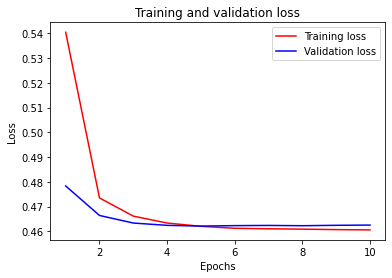

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss', color='r')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='b')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

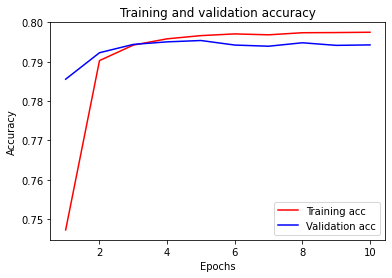

In [ ]:
plt.plot(epochs, acc, label='Training acc', color='r')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='b')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

> En estas gráficas observamos como a partir de la iteración 5, más o menos, el error y la exactitud de train y de test se igualan y se mantienen similares

## 6. Nuevos datos

- Teniendo ya un modelo entrenado y con unos resultados aceptables, podemos pasar a hacer pruebas con datos externos al dataset.
- Para ello primero añadiremos el vectorizador de texto que entrenamos en el punto 3 como una primera capa de la red neuronal, para que así podamos introducir los ejemplos a predecir directamente en la red y esta se encargue de todos los procesamientos necesarios para tratarlos. También añadiremos al final una capa de **Activación** que mediante la función sigmoide nos dará la predicción que buscamos  *(negativo (pred < 0.5) o positivo (pred > 0.5))*

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

- Podemos probar el modelo con datos sin preprocesar para ver que todo funciona correctamente:

In [ ]:
# Test it with `raw_test_ds`, which yields raw strings
predictions = export_model.predict(raw_test_ds_batched)
i = 0
tp = 0
fp = 0
tn = 0
fn = 0
for text_batch, label_batch in raw_test_ds_batched:
  for label in label_batch:
    if label == 1:
      if predictions[i] >= 0.5:
        tp += 1
      else:
        fn += 1
    elif label == 0:
      if predictions[i] >= 0.5:
        fp += 1
      else:
        tn += 1  
    
    i += 1

print("TP: {}, TN: {}\n FP: {}, FN: {}".format(tp, tn, fp, fn))
print("Total: ", i)

TP: 98804, TN: 92205
 FP: 27795, FN: 21196
Total:  240000


In [ ]:
print("Accuracy (Correct predictions): ", ((tp + tn) / (tp + fp + tn + fn)) * 100, '%')
print("Precision (Correct predicted positives): ", (tp/(tp + fp))* 100, '%')
print("Recall (Real positives captured): ", (tp/(tp + fn)) * 100, '%')
print("F1: ", 2*tp/(2*tp + fp + fn) * 100, '%')

Accuracy (Correct predictions):  79.58708333333333 %
Precision (Correct predicted positives):  78.04485027527863 %
Recall (Real positives captured):  82.33666666666667 %
F1:  80.1333338740222 %


> Vemos unos resultados aceptables y muy similares a los resultados que ya obtuvimos anteriormente

- Podemos ilustrar los buenos resultados del clasificador con una matriz de confusión:

In [ ]:
predictions[np.where(predictions >= 0.5)] = 1
predictions[np.where(predictions < 0.5)] = 0

In [ ]:
predictions = predictions.astype(int)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, predictions)
print(cm)

[[92205 27795]
 [21196 98804]]


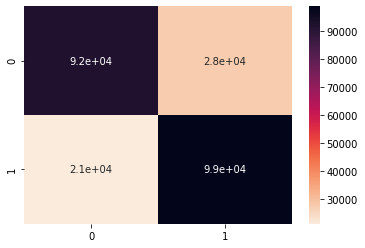

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True, cmap="rocket_r")

- Probamos también con varios strings de prueba:

In [ ]:
### Pruebas con ejemplos externos
examples = [
            "The movie was great!", # Se espera positivo
            "The movie was okay.", # Se espera positivo
            "The movie was terrible..." # Se espera negativo
]

predictions = export_model.predict(examples)
print('\n',predictions)
for p in predictions:
  if p >= 0.5:
    print("Positivo")
  else:
    print("Negativo")


 [[0.7997041 ]
 [0.6552448 ]
 [0.24262185]]
Positivo
Positivo
Negativo


- Exportamos el modelo ya entrenado para poder usarlo en otros notebooks:

In [ ]:
export_model.save('/content/drive/MyDrive/Mineria/tweet-sentiment-NN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mineria/tweet-sentiment-NN/assets
